To clone the data we make use of '!git clone' and make sure to point to the appropriate github repository. As we run this code it clones and allows us to make use of the driving data into Google Colab from the github repository. The when it is complete, using the '!ls' command to see what kind of data is inside the repository. by running it it will returns 'driving_log.csv IMG'.


In [37]:
!git clone https://github.com/mshahrasbi/Applied-Deep-Learning-Self-Driving-Car

fatal: destination path 'Applied-Deep-Learning-Self-Driving-Car' already exists and is not an empty directory.


In [38]:
!ls Applied-Deep-Learning-Self-Driving-Car/Projects/14-BehaviouralCloning/simulator-windows-64/data

driving_log.csv  IMG


The last 2 lessons consisted of connecting our model to the simylator and realized that our model was not perfect but performed decently well in the first track, but on the 2nd track it did not generalize to it at all as it failed almost immediately. This is essentially due to the small dataset that our model was trained on in order to tackle this issue of small dataset, let's revisit the data augmentation technique that we interduced in our previous section. data augmentation is the process of creating new data images using your existing dataset. Recall that this is done by applying transformations to your current set of images which results in a brand new set of images. This helps add variety to your dataset and helps the model learn more effeciently because it gets more data to work with it. Lets revisit code and make some modifications to help improve the training quality of our model. A satisfactory model should be able to drive around the frist and second track, as any accidents in s self driving car should be extermely rare as opposed to common place.
In this section we are going to take it up a notch and design our own data image generator.
In the previous section when dealing with the traffic sign dataset we used the image data generator provided to us by keras, however there are certain perks to designing your own image data generator, designing your own generator provides you with added flexibilty as it allows you to add or reome any of the augmentation techniques that you require. This can help you customize your own data augmentation to very specific data sets or to very specific applications.
Also this will show you how to create your own image data generator and the concept of data augmentation is not as defficult as it may initially sound. By designing our own data generator we will gain some transparency with regards to the process of data augmentation which will help us better understand why it is such a useful technique for improving the quality of the training process. 
 


Now the first step in creating our very own data generator is going to be the process of installing the relevant augmentation libraries the particular library that we are going to use for our data generator is referred to as the '**imgaug**'  library the image library. this library is a very useful library that supports a large range of augmentation techniques, that we can implement inside of our own generator.
while we are not going to use all the techniques available through imgaug, we are going to be able to customize our generator to use the augmentation techniques that will be the most beneficial for our self diriving car model.

So we are going to install imgaug:

In [39]:
!pip3 install imgaug

Then we import some augmentation functions from imgaug:

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

Now we need to define the augmentation techniques that we are going to use as individual functions that we will call as required.

In [41]:
datadir = 'Applied-Deep-Learning-Self-Driving-Car/Projects/14-BehaviouralCloning/simulator-windows-64/data'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


center  ...     speed
0  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg  ...  0.649786
1  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg  ...  0.627942
2  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg  ...  0.622910
3  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg  ...  0.619162
4  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg  ...  0.615438

[5 rows x 7 columns]

In [42]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)

data.head()

center  ...     speed
0  center_2018_07_16_17_11_43_382.jpg  ...  0.649786
1  center_2018_07_16_17_11_43_670.jpg  ...  0.627942
2  center_2018_07_16_17_11_43_724.jpg  ...  0.622910
3  center_2018_07_16_17_11_43_792.jpg  ...  0.619162
4  center_2018_07_16_17_11_43_860.jpg  ...  0.615438

[5 rows x 7 columns]

[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]


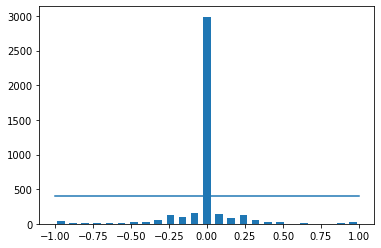

In [43]:
num_bins = 25
samples_per_bin = 400 #200
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
print(bins)
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data:  4053
removed:  2590
remaining:  1463


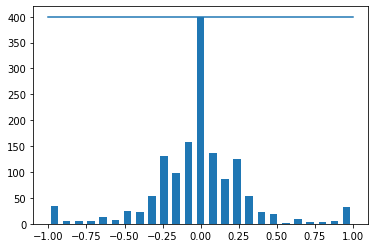

In [44]:
print('total data: ', len(data))

remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed: ', len(remove_list))

data.drop(data.index[remove_list], inplace=True)
print('remaining: ', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))

plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [45]:
print(data.iloc(1))
def load_image_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))

  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)

  return image_paths, steerings

image_paths, steerings = load_image_steering(datadir + '/IMG', data)

In [46]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size = 0.2, random_state = 6)
print('Training Sample: {}\nValid Smaples: {}'.format(len(X_train), len(X_valid)))

Training Sample: 1170
Valid Smaples: 293


Text(0.5, 1.0, 'Validation set')

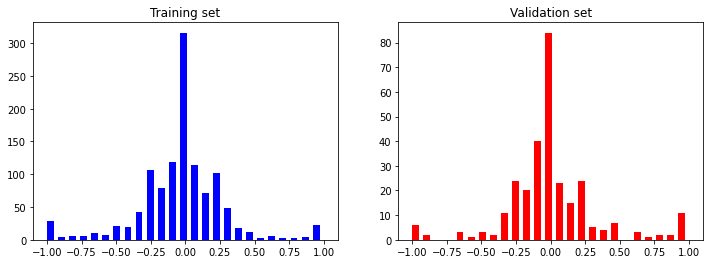

In [47]:
fig, axes = plt.subplots(1, 2,figsize=(12, 4))
axes[0].hist(y_train, bins = num_bins, width = 0.05, color = 'blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins = num_bins, width = 0.05, color = 'red')
axes[1].set_title('Validation set')


Lets begin our first augmentation technique, zooming. Zoming is relatively self-explanatory, we are basically just going to zoom into some of our images. Allowing our model to potentially get a closer look at some of the features in the image:

and this is where we are going to implement the image library we call 'iaa' and we call the zoom augmentation function. The zoom statement is stored inside  function called 'Affine' and the Affine function deals explicitly with affine type transformations which are simply transformations that perserve straight lines and plained with the object. scaling or zooming is the transformation that fits this category. Therefore we use the scale arguments and use a tuple to define the range of zoom that we require. In our application it would be more useful to zoom in to the image rather than out for improved feature extraction which means that we will start our range at one which implies no zoom and we will define the upper limit of our range as of 1.3, which means that we can zoom up to 30% into our image. The zoom function itself will select a random % of zoom wothin our defined range for each new augmented image. And now that we have defined the parameters of our zoom function we can return parameters and store them inside of a zoom variable. And now we simply use the 'zoom.augment_image' image command to actually apply the zoom parameters to our image and argumented. and finally we wrap this function up by storing this return value inside of an image variable and then returning this image. 
This is going to be our first augmentation function relatively short but very useful for data augmentation.

Let's add another function to visualize this augmentation. Let's begin by first selecting a random image from our training dataset to visualize, we can store this inside of variable we will call it image and let us access our data array image_path and select an arbitrary image to visualize, in our case we will pick a random integer between 0 and 1000 random in order to compare our original image with augmented image we need to define our 2 images idependently for our original_image, we read our image read image and store it inside of our original_image variable, and now for our zoomed_image we simply feed our original_image path into our pre-processing function zoom.

And now that we have defined both of our images we simply need to plot them side by side.

In [0]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

Text(0.5, 1.0, 'Zoomed Image')

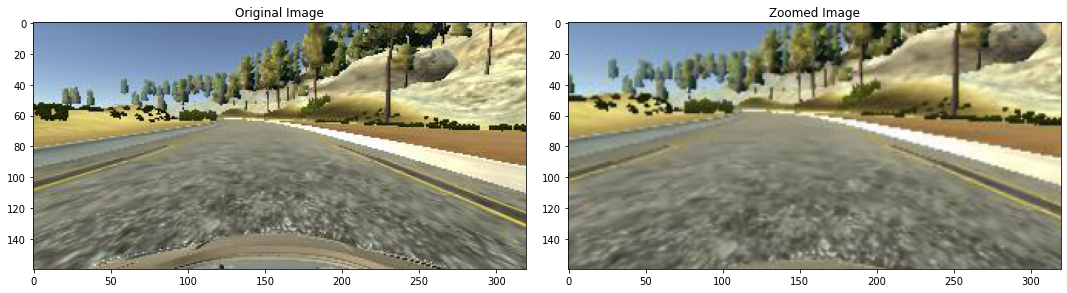

In [49]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

Now we can move on to our next augmentation image panning. Image panning is essentially just the horizontal or vertical translation of the image. So what we will do is on a new cell define a new function 'pan' which will take in a single image as an argument and inside of this function we are using 'iaa', and we call the augmentation function, which once again is stored inside a function aclled 'Affine', and it deals explicitly with affine type transformations which are simply transformations that preserve straight lines and planes objects. panning or translating is transformation that once again fits this category. Therefore we use the 'translate_percent' and define the x and y transaltion parameters, we are going to set the translation range for x as 10% rights or left in the x direction and for y the vertical and we will set the value as 10% up or down in either direction.  So overall we did was specify a horizontal range x setting the range between -0.1 and 0.1 meeting anywhere from 10% less the 10% right and similarly we do the same thing for thevertical Y setting the range between -0.1 and 0.1 up or down.
Now the pen function itself will select a random % of pan within our defined rangefor each new augmented image. And now that we defined the parameters of our pan function we can return these parameters and store them inside of a pan variable, and we use the augment_image to actually apply the pan parameters to our image and augment it. Finally we can wrap thei function up by storing this return value once again inside of the image variable and then returning this image.

In [0]:
def pan(image):
  pan = iaa.Affine(translate_percent= {"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

Text(0.5, 1.0, 'Panned Image')

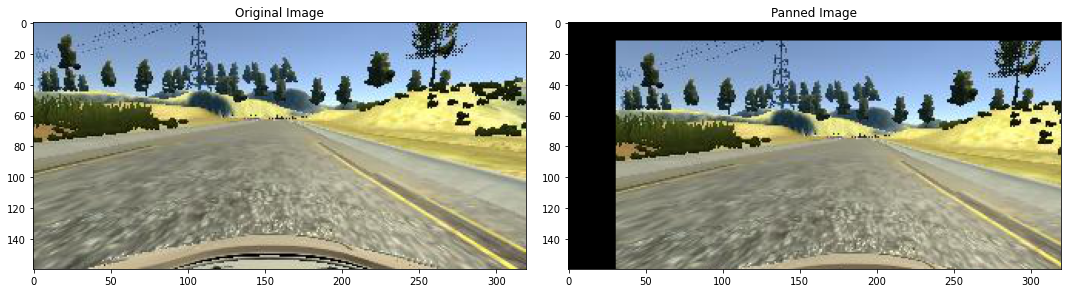

In [51]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

Now we can move to our next augmentation which is altering brightness which we will define in a new function, this function is essentially going to do is play around with the brightness of the image making it darker or lighter. our function name is img_random_brightness with takes a image as argument, which we call the iaa and we call the brightness aufmentation function the altered vrightness statement is called 'Multiply'. What this does is it essentially multiplies all the images inside the image with a specific value (multiplies all the pixel intensities inside the image, thus any pixel intensity multiplied by a value less than 1 will become darker) making image darker if the value is less than 1 and brighter if the value is larger than 1, we are going to focus more on creating darker images rather than lighter ones from experience, i have seen that the model reacts better to a higher fraction of a darker images, se we define the range for this multiplier value to be between 0.2 and 1.2 the brightness function itself will select a random value for the multiplier within our defined range for each now augmented image and now that we have defined the parameters of our brightness altering function, we can return these parameters and store them inside of a 'brightness' variable and we once again use 'brightness' augment_image to apply the brightness augmenting to our image itself and you can wrap this function up once again by storing this inside of an image variable and then returning the image.
Notice the subtle change in brightness, which means that the image must have been multiplied by a value close to 1, do note that the image gets a little bit darker, also indicating that the value was less than 1, but not by much. 

In [0]:
def img_random_brightness(image):
  brightness = iaa.Multiply((0.2, 1.2))
  image = brightness.augment_image(image)
  return image

Text(0.5, 1.0, 'Brightness Alter Image')

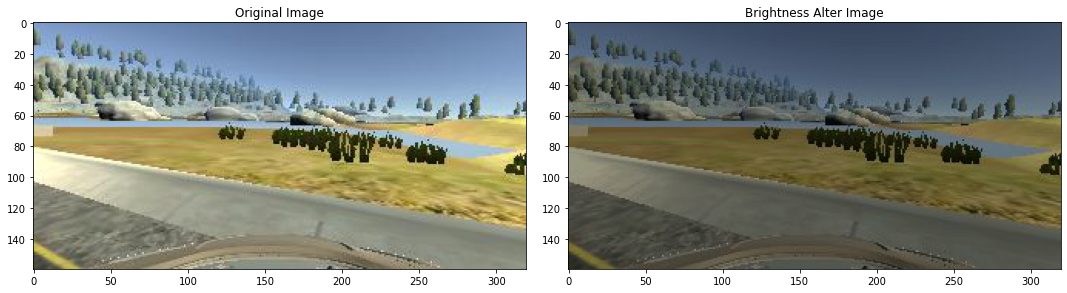

In [53]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_alter_image = img_random_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(brightness_alter_image)
axs[1].set_title('Brightness Alter Image')

Lets move on to our final augmentation technique that we will be using, and it is known as flipping. we have already talk about flipping earlier and we talked about it when we mentioned how data balancing is very important. Let's assume that our data was skewed completely towards the left turns what flipping would do is then randomly flip our images which helps to balance our datasets, we already have a relatively balanced dataset due to the fact that we drove our car in both directions around the training track and we also recommand that you do this while collecting your training data. However flipping can provide additional balancing so we will implement that as well. So we will define our flip function img_random_flip this function will require 2 arguments, image and respective steering angle of this image. In order to flip our image we are going to use a common cv2 function called Flip. This is capable of flipping our image horizontally, vertically or a combination of both. The 1st arg to the Flip function is our image and the 2nd arg determines the type of flip that we use, we have 3 options for the 2nd argument:
  0 = indicates a vertical flip 
  1 = indicates a horizontal flip
  -1 = indicates a combination of both 
as we require a horizontal flip, we aregoing to use a value of 1. Now the important thing to note is that in our dataset if the image is flipped we also need to flip the steering angle for the augmentation to be useful for our model. Therefore we take our steering_angle and convert it to a -ve value which effectively flipsour steering angle storing this new value in and we finished defining this function by returning our image and the new steering angle. obviously if you take the -ve angle assuming that it is to the left -0.75 becomes 0.75 flipping over to the right side. 

In [0]:
def img_random_flip(image, steering_angle):
  image = cv2.flip(image, 1)
  steering_angle = -steering_angle
  return image, steering_angle

Text(0.5, 1.0, 'Flipped Image - Steering Angle: -0.0')

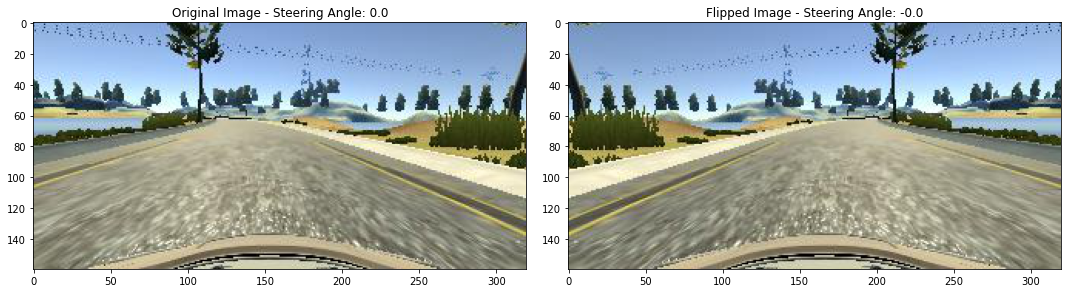

In [55]:
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]

original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image - Steering Angle: ' + str(steering_angle)) 

axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - Steering Angle: ' + str(flipped_steering_angle))

This is indeed going to help balance our dataset as now imagine our data is skewed only to right turns, now we have data that also accounts for left turns. Our data effectively is balanced.

These 4 augmentations that we just applied should be sufficient for our purposes and should add enough variety to our data set to improve the quality of our training process. With that being said many other augmentations are available for use as well through the imgaug library, however we will limit our scope to these 4.

Now we can move forward and randomize the occurrence of these augmentations. This is important as we do not want each augmentation to be applied to each new image generated. Applying all the augmentations to every generated image actually reduces the overall variety of the new datasets. Combining theaugmentations at random results in added varity in turn results in improved generalization by our model. As always we begin by defining a function random_augment and this function requires 2 args image and steering angle.
We are going to write a code that causes a certain augmentation function to run 50% of the time. This means that on average each augmentation will only be applied to 50% of the newly augmented images.

In [0]:
def random_augment(image, steering_angle):
  image = mpimg.imread(image)
  if np.random.rand() < 0.5:
    image = pan(image)
  if np.random.rand() < 0.5:
    image = zoom(image)
  if np.random.rand() < 0.5:
    image = img_random_brightness(image)
  if np.random.rand() < 0.5:
    image, steering_angle = img_random_flip(image, steering_angle)

  return image, steering_angle

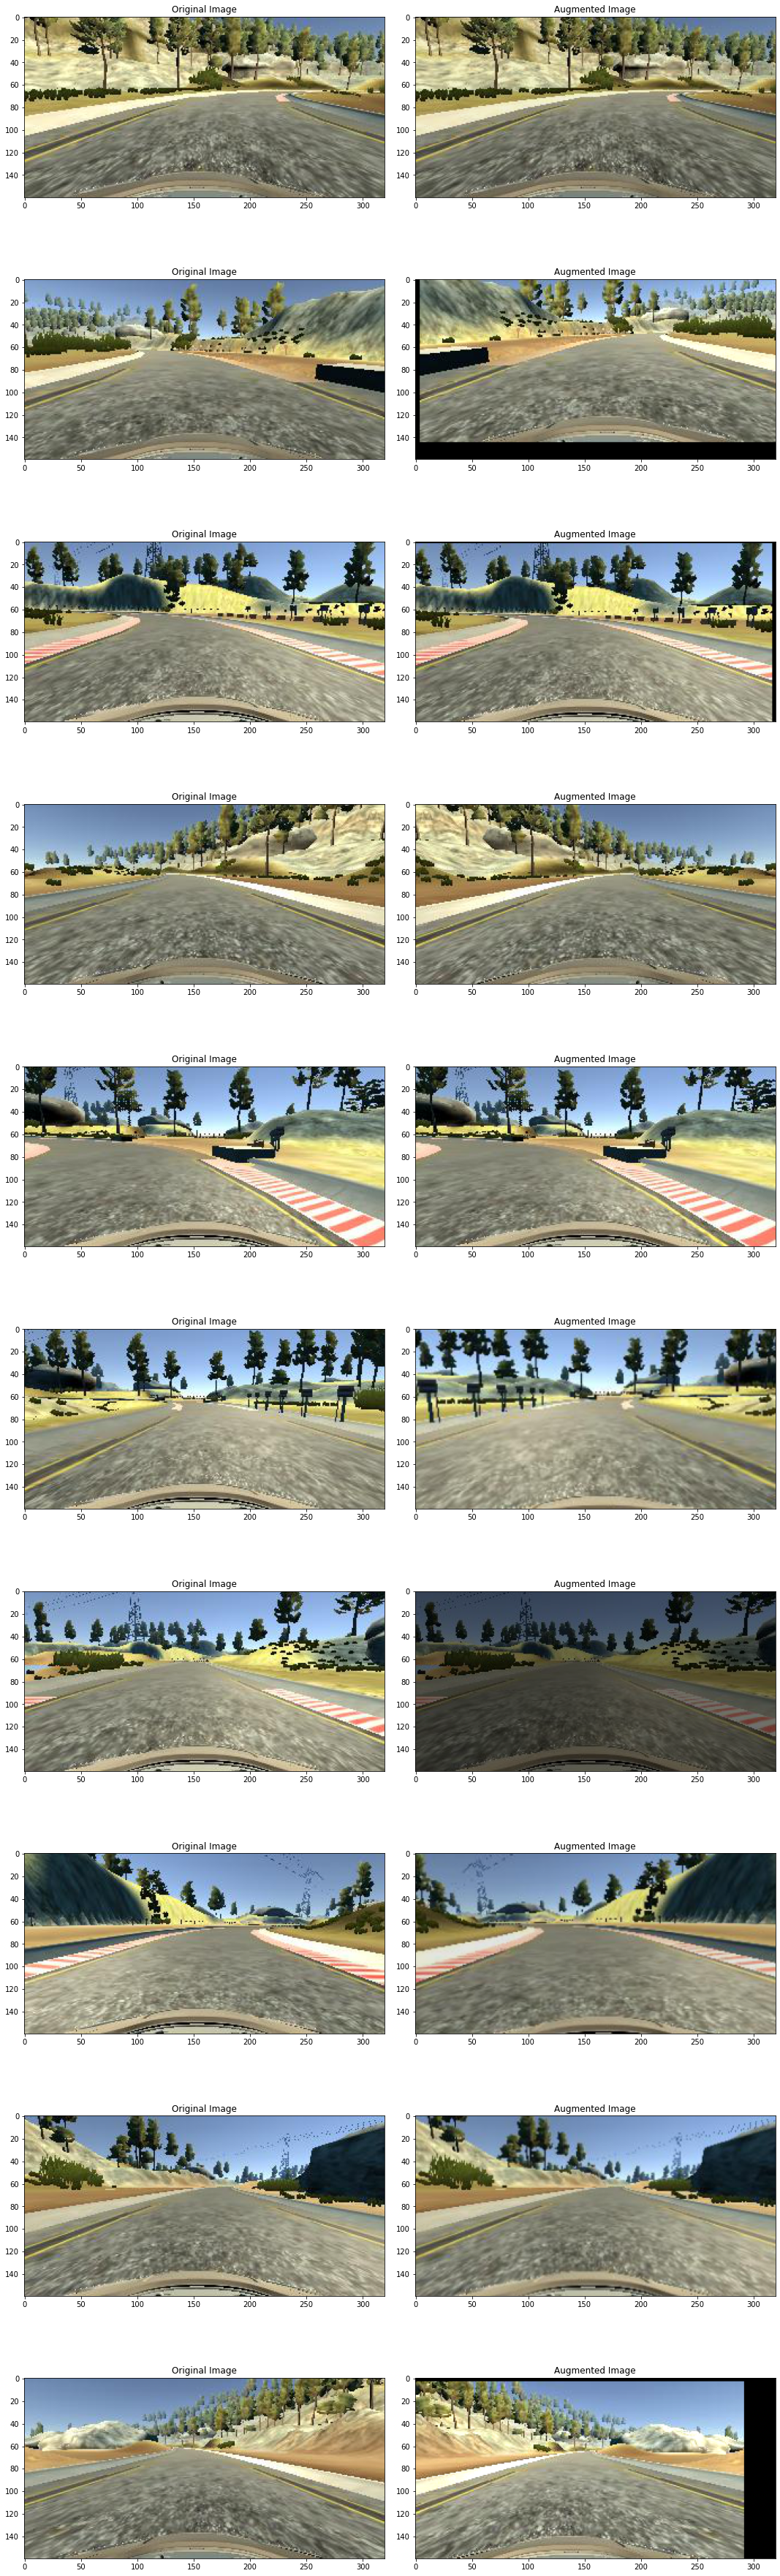

In [57]:
ncols = 2
nrows = 10

fig, axs = plt.subplots(nrows, ncols, figsize=(15, 50))
fig.tight_layout()

for i in range(nrows):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]

  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)

  axs[i][0].imshow(original_image)
  axs[i][0].set_title('Original Image')

  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title('Augmented Image')


**Batch Generator**
Now we fully defined our augmentation functions and ensure a random occurrence of each augmentation technique we are ready to finalize our image data generator. The image data genrator essentially puts everything in the section togather. Our generator will take input data create a defined number of augmented sample images along with labels and the returns these augmented images with their respective labels, it is relatively striaghtforward concept.
However the main benefit of the generator is that it can create augmented images on the fly rather than augmenting all your images at one time and storing them usung valuable memory space., the generator allows you to create small batches of images at a time only when the generator is actually called. This is much more memory efficient as data is only used when it is required rather than bing stored in memory even when it is not being used.

Note: 
Small Dataset:
    fit()
    predict()
Larger Dataset
    fit_generator()
    predict_generator()
Since fit() requires the entire dataset as a numpy array in memory, which is why for larger datasets, we make use of fit_generator(), to generate augmented images on the fly when needed, and this is done in batches.

This becomes all the more relevant with this section of the course as we are now dealing with very large image and file sizes.
Our previous traffic signe code had images that were 32x32 which is very small in comparison to our images that are 320x160, these memory issues become even more serious with larger datasets which makes the use of an image generator all the more important. So let's conclude the process of creating our very own image generator by defining the batch_generator(), this function requires a total of 4 arguments; 1st being the image_paths for our dataset, 2nd being the respective steering_ang for these images, 3rd is batch_size which tells our generator the size of the batch images it should create, 4th is a variable that will be referred to as istraining, this varaible essentially acts as a booling representing either true or false. It is set to true when the data being fed into the generator will be training data, flase it is vaidation data.
We don't want to validate our model on augmented data. validation data should closely resemble the exact data that the car should expect in the simulation, while training data can be augmented to help our model generalize. Therefore as you may expect our batch generator is going to handle training images differently than it handles validation images
Let discuss the architecture of the **batch_generator** function.
This function is not like other typical functions. Normal functions begin executing the functions as first line and continue until they hit some kind of return tatement at the end of the function. At this point any of the local values inside the function are re-initialized and any new call to the function re-creates everything these functions are referred to as subroutines (Subroutines are a way to break a program into building blocks that can be resused. if you think of regular functions as resuable chunks of code, they can be used to solve a problem once, and can then be reused to solve the same solution whenever needed)

This however is where our batch_generator function differs, the batch_generator acts like a co-routine, which means that the batch_generator uses the 'yield' keyword instead of the return keyword. while the yield keyword still returns the desired output of the batch_generator it also saves all the initialized values inside the batch generator, this means that when the generator is called again the values inside do not re-initialize but instead take on thier old values. Now that we know the theory behind the generator function lets implement it. we begin the batch function with a while true which is a loop that will run indefinitely. This loop ensures that our generator function runs continuously and only stops momentarily for our yield statement. we then initialize our batch_img list to empty list and our batch_steering list to empty list. These arrays will store our newly augmented images and thier respective steering angles.
Next we define a for loop a range of batch_size, with each iteration of the loop we create a new augmented image as such we ned toietrate enough times to create enough images for our batch size, inside this loop we are going to simply augment and preprocess randomly selected images from our dataset.





In [0]:
def img_preprocess(img):
  img = img[60:135, :, :]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3, 3), 0)
  img = cv2.resize(img, (200, 66))
  img = img/255
  return img


Text(0.5, 1.0, 'Preprocessed Image')

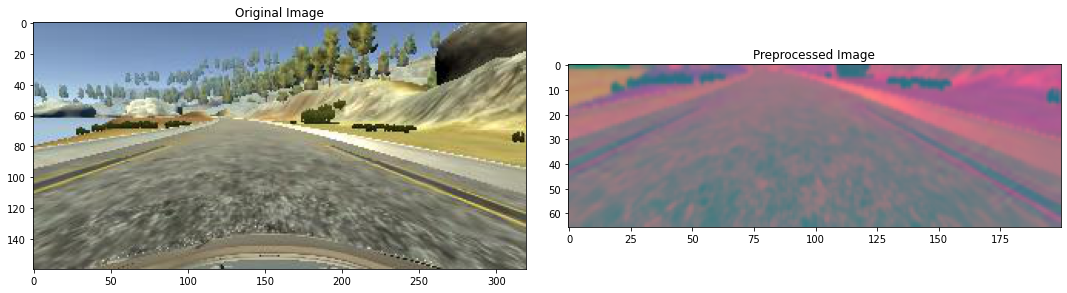

In [59]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)
#
fig, axs = plt.subplots(1, 2, figsize = (15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [0]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  while True:
    batch_img = []
    batch_steering = []

    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)

      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]

      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)

    yield (np.asarray(batch_img), np.asarray(batch_steering))

**Fit Generator**
we use the next() statement to request the next batch of images from our generator. The next() function simply calls an iterator item and retrieves the next item for it, within next() we call the batch_generator and feed it our training data X_train , y_train. we will define a small batch of 1 just for testing purposes and our training boolean will get a value of 1 as well 1 for true, as we are dealing with training images we want it to go in the if statement and get augmented as such we can store the returned values inside of an X_train_gen array and y_train_gen array. and do the same for validation dataset and passing 0 so as to denote false and it going inside of the else statements, since we are dealing with validation data we do not want to augment that data.
Lets plot the 2 generated images to see how our training data is handled differently than our validation. we also want to plot these images to verify that our generator is working as espected.
so running the code shows us our augmented and preprocessed training image side by side with our validation image which was not augmented but it was preprocessed.
you can see that while our training images have more added variety due to the augmentations being applied, the validation images consistent as they have not been aufmented. This reinforces the idea that augmenting your training sets helps your model generalize to new data.

Text(0.5, 1.0, 'Validation Image')

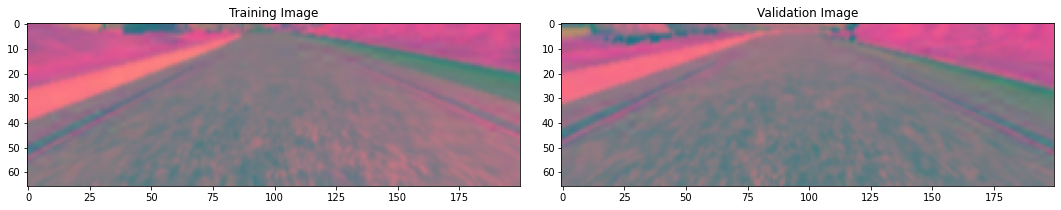

In [61]:
X_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
X_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

fig, axs = plt.subplots(1, 2, figsize = (15, 10))
fig.tight_layout()
axs[0].imshow(X_train_gen[0])
axs[0].set_title('Training Image')
axs[1].imshow(X_valid_gen[0])
axs[1].set_title('Validation Image')

So now we have been ensured that our image generator that we designed is working as intended, the augmentation techniques seem to be applied correctly and the batches are being generated as expected. Now we can move on to actually training our model using this image generator and seeing if it actually helps our car drive around the simulated tracks. 
So we have to modify our fit function.

In [0]:
# X_train = np.array(list(map(img_preprocess, X_train)))
# X_valid = np.array(list(map(img_preprocess, X_valid)))

In [0]:
# plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
# plt.axis('off')
# print('Shape X train: ' , X_train.shape) # 3 channel of size 200x66 and 1010 images

In [0]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, 5, 5, subsample = (2, 2), input_shape = (66, 200, 3), activation = 'elu'))
  model.add(Convolution2D(36, 5, 5, subsample = (2, 2), activation = 'elu'))
  model.add(Convolution2D(48, 5, 5, subsample = (2, 2), activation = 'elu'))    
  model.add(Convolution2D(64, 3, 3, activation = 'elu'))

  model.add(Convolution2D(64, 3, 3, activation = 'elu'))
  #model.add(Dropout(0.5))

  model.add(Flatten())

  model.add(Dense(100, activation = 'elu'))
  #model.add(Dropout(0.5))

  model.add(Dense(50 , activation = 'elu'))
  #model.add(Dropout(0.5))

  model.add(Dense(10 , activation = 'elu'))
  #model.add(Dropout(0.5))
  
  model.add(Dense(1))

  optimizer = Adam(lr = 1e-4)
  model.compile(loss = 'mse', optimizer = optimizer)
  return model

In [65]:
model = nvidia_model()
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)              

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), act

we will make the appropriate modifications to integrate our batch_generator into our training process. we start by modifying our input data. as our input data is going to be created real time by our batch generator.
(since we will be dealing with a huge augmented dataset, we must genrate it on the fly, in batches, with the generator we just created. Thus we also require fit.generator rather than fit)
we are going to fed batch_generator the appropriate inputs to get an augmented data set on the fly and now this function requires a total of 4 arguments, 1st being the X_train for our dataset, 2nd being the y_train labels for these images, 3rd being is batch_size which tells our generator the size of thebatch of images it should create. we are going to use 100 meaning our generator generates 100 images per step. 4th is istraining variable, set to true when the data being fed into the generator is actually training data as is the case. next we will add a new steps_per_epoch referring to the amount of steps that we will use per epoch and we will set this = 300, this means that we will augment a total of 100 * 300 = 30000 images per epoch, this is significantly higher than the size of our dataset, which recall was about 1000 and it shows us just an image generator can be. what is more is that storing this many images would be very intensive in our memory as the images are so large. however with the generator the images are created on the fly and demand less memory resources. using 30000 images to train with per epoch is going to take a long time to train. But the quality of training will be very effective as we are using such a high number of images per epoch, let's reduce the number of epoch to 10, and as we are also generating our validation data we need to input a similar call to batch_generator for validation_data, however the istraining value to 0 as this is no longer training data. validation_steps for our model as we don't need as high a number of validation images we will use 200 steps.     

After runing this for the first time, we got a relatively low validation error of 0.0526 and a low error for the training lost 0.0815. However this discrepency between the validation and training error is relatively high. when we plot our loss and visulize our training process, and clearly as expected the loss of values for the training and validation are relatively far apart. This can be fixed by removing the 'dropout' layers that we added to our model earlier as we are now using augmented data overfitting is not as much of an issue and we don't actually need the 4 dropout layers in our model.
Again rerun the code to retrain our model, 
We have some clutter in our code, first and formost we won't be processing training and validation images in this way anymore since recall all the preprocessing and augmentation of training and validation images is done inside of the generator in real time on the fly while the model is being trained inside of the fit_generator

Now we rerun all the code again, what is more is that removing the dropout layer is very effective, our model now has a very low validation loss and a very low training loss as well, the gap between the loss values has decreased significantly and is indicative of a properly trained model andhaving plotted the loss as well, we can see that our loss values are much closer togather now although there seems to be some discrepencies, this is not really the best graph, plus training error seems like it has yet to converge. So what I am going to di is actually prolong the training process by adjusting to a leraning rate of 1e-4.
Now we rerun the code again, our plot seems the error is relatively low now. So this model is ready to export and be validate it in simulator.

In [66]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1), 
                              steps_per_epoch=300, 
                              epochs=10, 
                              validation_data=batch_generator(X_valid, y_valid, 100, 0), 
                              validation_steps=200, 
                              verbose=1, 
                              shuffle=1)

Epoch 1/10
300/300 [==============================] - 429s 1s/step - loss: 0.0762 - val_loss: 0.0661
Epoch 2/10
300/300 [==============================] - 429s 1s/step - loss: 0.0611 - val_loss: 0.0533
Epoch 3/10
300/300 [==============================] - 435s 1s/step - loss: 0.0560 - val_loss: 0.0695
Epoch 4/10
300/300 [==============================] - 425s 1s/step - loss: 0.0515 - val_loss: 0.0457
Epoch 5/10
300/300 [==============================] - 423s 1s/step - loss: 0.0466 - val_loss: 0.0407
Epoch 6/10
300/300 [==============================] - 417s 1s/step - loss: 0.0418 - val_loss: 0.0393
Epoch 7/10
300/300 [==============================] - 421s 1s/step - loss: 0.0415 - val_loss: 0.0306
Epoch 8/10
300/300 [==============================] - 419s 1s/step - loss: 0.0387 - val_loss: 0.0356
Epoch 9/10
300/300 [==============================] - 418s 1s/step - loss: 0.0377 - val_loss: 0.0346
Epoch 10/10
300/300 [==============================] - 421s 1s/step - loss: 0.0355 - val_lo

Text(0.5, 0, 'Epochs')

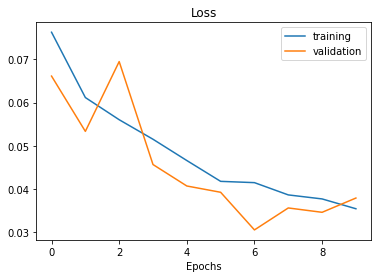

In [67]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epochs')

In [0]:
model.save('model.h5')

Then we need to download the saved model. 

In [0]:
from google.colab import files
files.download('model.h5')

AFter loading model to simulator, the vehicle it seems to sway to the side a little bit, it seems to catch itself and return back to the track (A very effective way to ensure the car doesn't crash is to record recovery laps, and add it to your training data) I am not a fan of how it is swaying back and forth, this can be attributed to us removing too much of the zero angle. we initially drove our car in the training track with hopes of driving straight down the middle in order to have the car ultimately emulate our behavior and driving straight most of the time. But then upon retrieving our data we noticed an extreme bias where the highest frequency of agnles was at 0 which if we were to train the model on, it would create a problem for the NN which could bias the model towards predicting a z agnle all the time resulting in a car that is biased towards driving straight all the time.
So what we did, placed a threshold of 200 samples removing many of our angle samples ensuring that data isn't heavily skewed towards the 0 turning angles. Ultimately we now have to lot of left and lot of right steering angles relative to our middle. At the same time it seems like we removed too much of our 0 steering angle, we still want the car to mostly favor center lane driving and a recall our initial goal was to have our car drive straight down the middle of most of the time, so what we will do is actually specify a threshold of 400 rather than 200, therefor increasing the bais towards center lane driving. Although at the same time we are still going to have a significant amount of left and right steering data to balance it out.
So re run the code again.   